In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.font_manager as font_manager
from matplotlib import rc

rc('text', usetex=True)

rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# hfont = {'fontname':'Times'}


In [2]:
def rotate(l, n):
    return l[-n:] + l[:-n]

In [3]:
import pandas as pd
import geopandas as gpd
pd.options.display.max_columns = 999

#import plotly
#import plotly.graph_objs as go
#import plotly.offline as offline
#offline.init_notebook_mode(connected=True)
import plotly.express as px

from mpl_toolkits.axes_grid1 import make_axes_locatable
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 12)
import seaborn as sns



# For changes in .py
%reload_ext autoreload
%autoreload 2

import numpy as np

import missingno as msno

stats = ['skew', 'mad', 'kurt']


import qgrid

def qg(df):
    return(qgrid.show_grid(df,show_toolbar=True, grid_options={'forceFitColumns': False}))

import itertools
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', -1)
pd.set_option('display.max_colwidth', 100)

import requests
import json
import xmltodict
import re
import urllib.request as urllib2
import io
import yaml

import math
import pysal as ps

from pysal.esda.mapclassify import Quantiles, Equal_Interval, Fisher_Jenks


import warnings
warnings.filterwarnings('ignore')
import imageio

Populating the interactive namespace from numpy and matplotlib


/home/m/python/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning:

pylab import has clobbered these variables: ['rc']
`%matplotlib` prevents importing * from pylab and numpy



In [4]:
var_dissolve = 'regiao'

maps        = gpd.read_file('../maps/sp_municipios.json',encoding='utf-8')

# maps_meso = maps.dissolve(by='nome_mesorregiao', as_index=False)

maps_meso = gpd.read_file('../maps/sp_regioes_ssp.json', encoding='utf-8')

In [8]:
ocorrencias = pd.read_csv('../dados/ssp_ocorrecencias_registradas.csv', encoding='utf-8')
atividades = pd.read_csv('../dados/ssp_atividade_policial.csv', encoding='utf-8')
codigo_ibge  = pd.read_csv('../dados/ssp_codigo_ibge.csv', encoding='utf-8')
populacao    = pd.read_csv('../dados/populacao_municipios_2001_to_2019.csv', encoding='utf-8')

In [9]:
ocorrencias = pd.merge(ocorrencias,atividades, on=['municipio','regiao','ano','mes','delegacia'], how='outer')

#put the geocode
ocorrencias = pd.merge(codigo_ibge, ocorrencias, how='inner', on='municipio')

#put the population
cols = ['geocodigo','ano','populacao']
populacao = populacao[cols]
ocorrencias = pd.merge(populacao, ocorrencias, how='inner', on=['geocodigo','ano'])


In [19]:
for col in ocorrencias.columns[7:-1]:
    ocorrencias[col] = pd.to_numeric(ocorrencias[col], errors='coerce')

In [20]:
#groupy in anual statistics
ocorrencias_anual = ocorrencias.groupby(by=['geocodigo','ano','populacao','municipio','regiao','mes'], as_index=False).sum()

In [21]:




ocorrencias_anual['ano'] = ocorrencias_anual['ano'].astype(int)
ocorrencias_anual['populacao'] = ocorrencias_anual['populacao'].astype(float).astype(int)

In [22]:
# for col in ocorrencias_anual.columns[5:]:
#     ocorrencias_anual[col] = round(ocorrencias_anual[col]/ocorrencias_anual['populacao'].astype(float) * 10000, 1)

In [23]:
#put the geocode and regions hierarchy
ocorrencias_anual = pd.merge(ocorrencias_anual, maps[['geocodigo','nome_mesorregiao','nome_microrregiao']], on='geocodigo', how='inner')

#put the regions of ssp in maps
maps_regioes = pd.merge(ocorrencias_anual[['geocodigo','regiao']], maps, on='geocodigo', how='inner')
maps_regioes = gpd.GeoDataFrame(maps_regioes)

In [68]:
cols = [var_dissolve,'ano','mes','populacao'] + ocorrencias_anual.columns[6:42].tolist()
df_final = ocorrencias_anual[cols].groupby(by=[var_dissolve,'ano','mes'], as_index=False).sum()


## Graphs

In [69]:
month_replace = {
    'Abr':4,'Ago':8,'Dez':12,'Fev':2, 'Jan':1,'Jul':7,
    'Jun':6,'Mai':5,'Mar':3,'Nov':9,'Out':10,'Set':11
}

df_final['mes'] = df_final['mes'].replace(month_replace)
df_final['data'] = df_final['ano'].astype(str) + "-" + df_final['mes'].astype(str)
df_final['data'] = pd.to_datetime(df_final['data'])

df_final= df_final.sort_values(by='data')

In [70]:
df_final_estado = df_final.groupby(by=['ano','mes','data'],as_index=False).sum()
df_final_estado[var_dissolve] = 'Estado'

df_final = pd.concat([df_final_estado,df_final], axis=0)

cols = rotate(df_final.columns.tolist(),5)
df_final = df_final[cols]
df_final['ano'] = df_final['ano'].astype(float).astype(int)

In [71]:
for col in df_final.columns[5:-1]:
    df_final[col] = round(df_final[col].astype(float)/df_final['populacao'].astype(float) * 100000, 1)

In [78]:
df_plot = df_final.copy()

mask = (df_plot['mes']<=8)

df_plot = df_plot[mask]

df_plot = df_plot.groupby(by=['ano',var_dissolve], as_index=False).sum()

In [79]:
df_plot.head(0)

,ano,regiao,data_de_captura_x,mes,populacao,ESTUPRO,ESTUPRO DE VULNERÁVEL,FURTO - OUTROS,FURTO DE VEÍCULO,HOMICÍDIO CULPOSO OUTROS,HOMICÍDIO CULPOSO POR ACIDENTE DE TRÂNSITO,HOMICÍDIO DOLOSO (2),HOMICÍDIO DOLOSO POR ACIDENTE DE TRÂNSITO,LATROCÍNIO,LESÃO CORPORAL CULPOSA - OUTRAS,LESÃO CORPORAL CULPOSA POR ACIDENTE DE TRÂNSITO,LESÃO CORPORAL DOLOSA,LESÃO CORPORAL SEGUIDA DE MORTE,Nº DE ARMAS DE FOGO APREENDIDAS,Nº DE FLAGRANTES LAVRADOS,Nº DE INFRATORES APREENDIDOS EM FLAGRANTE,Nº DE INFRATORES APREENDIDOS POR MANDADO,Nº DE PESSOAS PRESAS EM FLAGRANTE,Nº DE PESSOAS PRESAS POR MANDADO,Nº DE PRISÕES EFETUADAS,Nº DE VEÍCULOS RECUPERADOS,Nº DE VÍTIMAS EM HOMICÍDIO DOLOSO (3),Nº DE VÍTIMAS EM HOMICÍDIO DOLOSO POR ACIDENTE DE TRÂNSITO,Nº DE VÍTIMAS EM LATROCÍNIO,OCORRÊNCIAS DE APREENSÃO DE ENTORPECENTES(1),OCORRÊNCIAS DE PORTE DE ENTORPECENTES,OCORRÊNCIAS DE PORTE ILEGAL DE ARMA,OCORRÊNCIAS DE TRÁFICO DE ENTORPECENTES,ROUBO - OUTROS,ROUBO A BANCO,ROUBO DE CARGA,ROUBO DE VEÍCULO,TENTATIVA DE HOMICÍDIO,TOTAL DE ESTUPRO (4),TOTAL DE ROUBO - OUTROS (1)


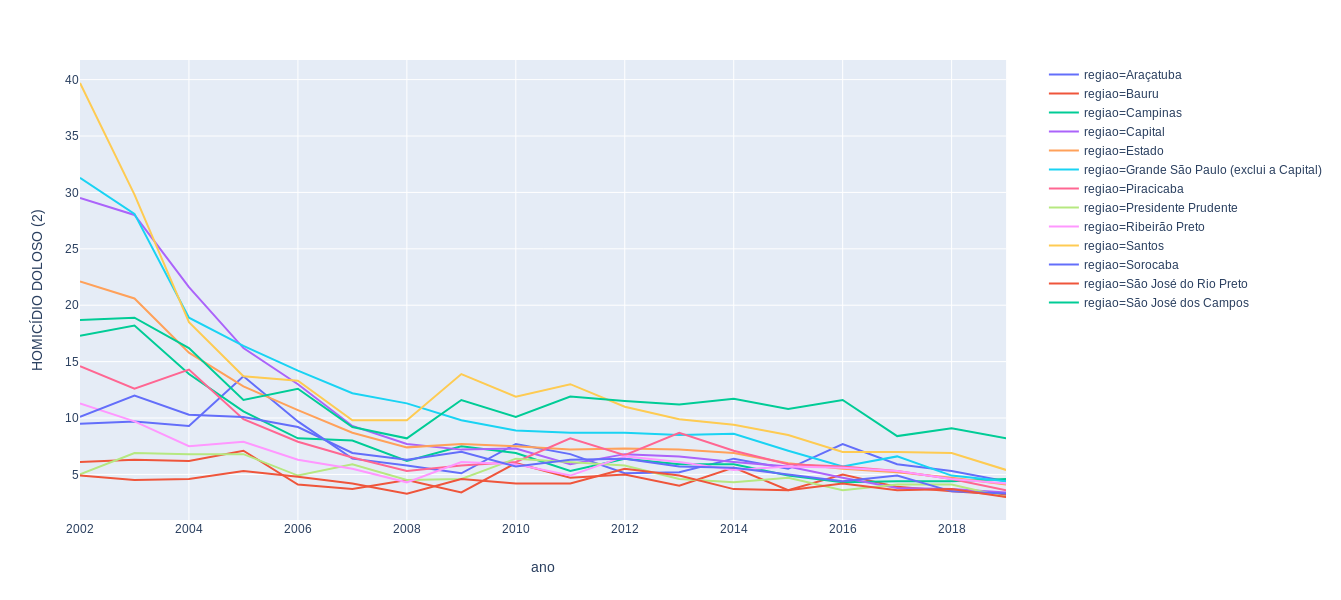

In [80]:
var = "HOMICÍDIO DOLOSO (2)"

fig = px.line(df_plot, x="ano", y=var, color=var_dissolve, )
fig.show()

## Maps

In [43]:
###put the geometry
df_final = pd.merge(df_final, maps_meso, on=var_dissolve, how='outer')

df_final = gpd.GeoDataFrame(df_final)


df_final['coords'] = df_final['geometry'].apply(lambda x: x.representative_point().coords[:])
df_final['coords'] = [coords[0] for coords in df_final['coords']]

In [44]:
df_final['regiao'].unique()

array(['Araçatuba', 'Bauru', 'Campinas', 'Capital',
       'Grande São Paulo (exclui a Capital)', 'Piracicaba',
       'Presidente Prudente', 'Ribeirão Preto', 'Santos', 'Sorocaba',
       'São José do Rio Preto', 'São José dos Campos'], dtype=object)

In [45]:
if var_dissolve == 'nome_mesorregiao':

    meso_rename = {
        'Macro Metropolitana Paulista':'Metrop. Paulista',
        'Metropolitana de São Paulo':'Metrop. de São Paulo',
        'Vale do Paraíba Paulista':'Vale do Paraíba'
    }

    df_final['nome_mesorregiao'] = df_final['nome_mesorregiao'].replace(meso_rename)
elif var_dissolve=='regiao':
    regiao_rename = {
        'Grande São Paulo (exclui a Capital)':'Grande SP'
    }

    df_final['regiao'] = df_final['regiao'].replace(regiao_rename)

In [46]:
df_final.head(0)

,regiao,ano,mes,populacao,HOMICÍDIO DOLOSO (2),Nº DE VÍTIMAS EM HOMICÍDIO DOLOSO (3),HOMICÍDIO DOLOSO POR ACIDENTE DE TRÂNSITO,Nº DE VÍTIMAS EM HOMICÍDIO DOLOSO POR ACIDENTE DE TRÂNSITO,HOMICÍDIO CULPOSO POR ACIDENTE DE TRÂNSITO,HOMICÍDIO CULPOSO OUTROS,TENTATIVA DE HOMICÍDIO,LESÃO CORPORAL SEGUIDA DE MORTE,LESÃO CORPORAL DOLOSA,LESÃO CORPORAL CULPOSA POR ACIDENTE DE TRÂNSITO,LESÃO CORPORAL CULPOSA - OUTRAS,LATROCÍNIO,Nº DE VÍTIMAS EM LATROCÍNIO,TOTAL DE ESTUPRO (4),ESTUPRO,ESTUPRO DE VULNERÁVEL,TOTAL DE ROUBO - OUTROS (1),ROUBO - OUTROS,ROUBO DE VEÍCULO,ROUBO A BANCO,ROUBO DE CARGA,FURTO - OUTROS,FURTO DE VEÍCULO,OCORRÊNCIAS DE PORTE DE ENTORPECENTES,OCORRÊNCIAS DE TRÁFICO DE ENTORPECENTES,OCORRÊNCIAS DE APREENSÃO DE ENTORPECENTES(1),OCORRÊNCIAS DE PORTE ILEGAL DE ARMA,Nº DE ARMAS DE FOGO APREENDIDAS,Nº DE FLAGRANTES LAVRADOS,Nº DE INFRATORES APREENDIDOS EM FLAGRANTE,Nº DE INFRATORES APREENDIDOS POR MANDADO,Nº DE PESSOAS PRESAS EM FLAGRANTE,Nº DE PESSOAS PRESAS POR MANDADO,Nº DE PRISÕES EFETUADAS,Nº DE VEÍCULOS RECUPERADOS,TOT. DE INQUÉRITOS POLICIAIS INSTAURADOS,geometry,coords


In [31]:
ano = 2018
var = "OCORRÊNCIAS DE APREENSÃO DE ENTORPECENTES(1)"

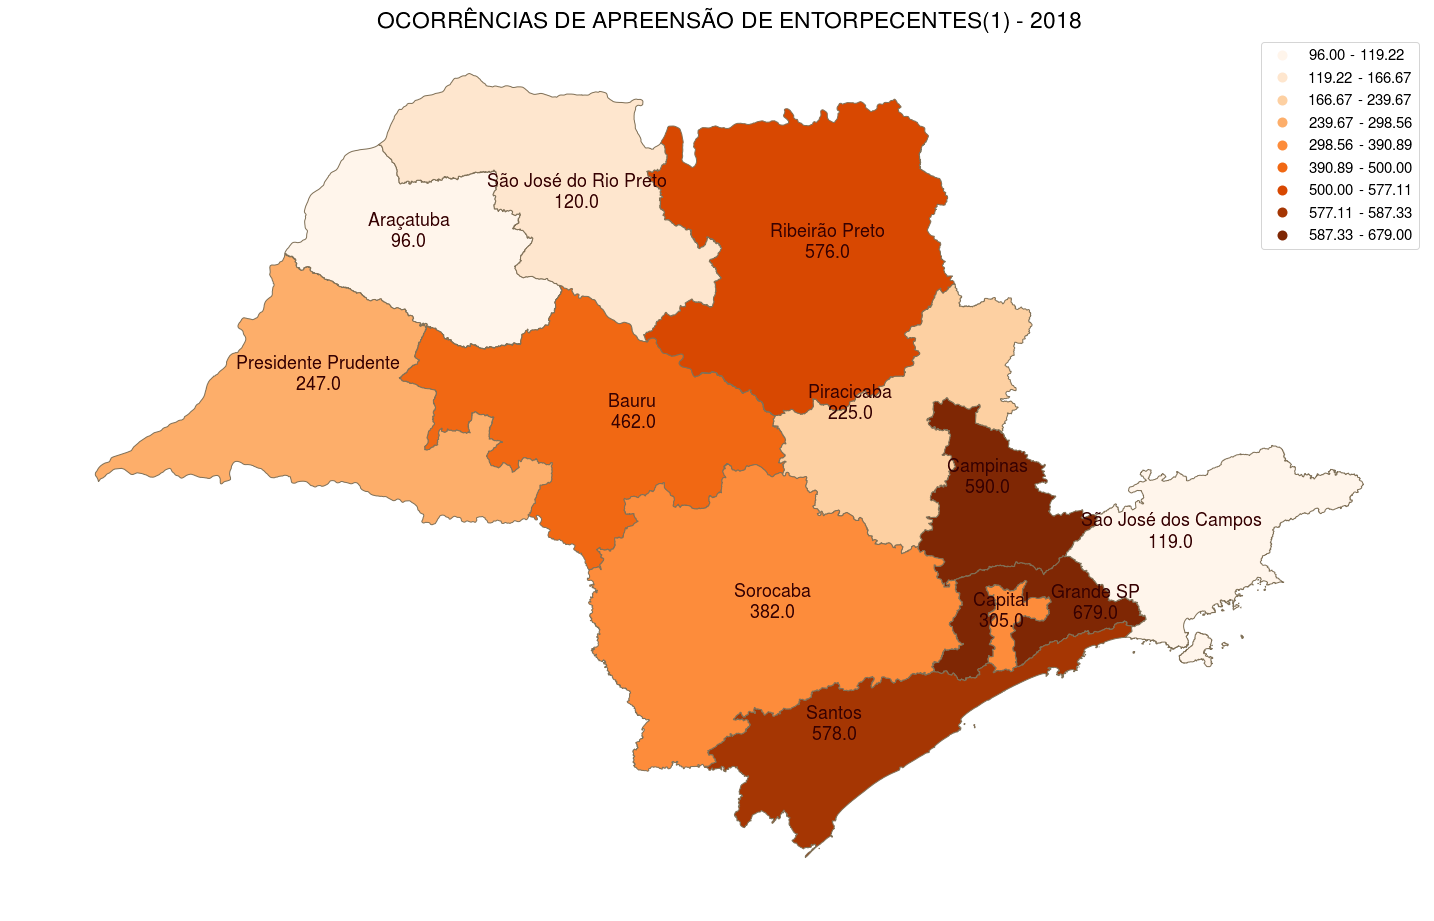

In [141]:
zmin = min(df_final[var])
zmax = max(df_final[var])

mask = df_final['ano']==ano
df_test=df_final[mask]


###--------SP--------###
fig = plt.figure(figsize=(25,25))
ax  = fig.add_subplot(1,1,1)
divider = make_axes_locatable(ax)

ax.set_title('{} - {}'.format(var,df_test['ano'].unique()[0]), fontsize=23)
mask = df_test[var].notnull()
df_test = df_test[mask]
# df_test['dado']=df_test['dado'].fillna(-1)
# df_test['dado'] = np.log(df_test['dado'])


# df_test.plot(column=var,ax=ax, legend=True,cmap='Oranges', edgecolor = "#ffffff",  scheme='user_defined', classification_kwds={'bins':[15, 18,19,20,22,35,40,45,60]}, )
df_test.plot(column=var ,ax=ax, legend=True,cmap='Oranges', edgecolor = "#807158" , scheme='quantiles',k=9)

# df_test.plot(column=var ,ax=ax, legend=True,cmap='Oranges', edgecolor = "#ffffff" , scheme='quantiles',k=9,  vmin=zmin, vmax=zmax)
ax.axis('off')

for idx, row in df_test.iterrows():
    plt.annotate(s=row[var_dissolve] + "\n" + str('{:.1f}'.format(row[var])), xy=row['coords'],fontsize=18,
                 horizontalalignment='center', color='#360102', **hfont)


plt.rc('legend',fontsize='large')


In [157]:
def plot_map(df_final,var,ano):
    zmin = min(df_final[var])
    zmax = max(df_final[var])

    mask = df_final['ano']==ano
    df_test=df_final[mask]


    ###--------SP--------###
    fig = plt.figure(figsize=(25,25))
    ax  = fig.add_subplot(1,1,1)
    divider = make_axes_locatable(ax)
    
    ax.set_title('{} - {}'.format(var,df_test['ano'].unique()[0]), fontsize=23)
    mask = df_test[var].notnull()
    df_test = df_test[mask]
    # df_test['dado']=df_test['dado'].fillna(-1)
    # df_test['dado'] = np.log(df_test['dado'])

    

    # df_test.plot(column=var,ax=ax, legend=True,cmap='Oranges', edgecolor = "#ffffff",  scheme='user_defined', classification_kwds={'bins':[15, 18,19,20,22,35,40,45,60]}, )
    df_test.plot(column=var ,ax=ax, legend=True,cmap='Oranges', edgecolor = "#807158" , scheme='quantiles',k=9)

    # df_test.plot(column=var ,ax=ax, legend=True,cmap='Oranges', edgecolor = "#ffffff" , scheme='quantiles',k=9,  vmin=zmin, vmax=zmax)
    ax.axis('off')
    
    
    for idx, row in df_test.iterrows():
        plt.annotate(s=row[var_dissolve] + "\n" + str('{:.1f}'.format(row[var])), xy=row['coords'],fontsize=18,
                     horizontalalignment='center', color='#360102')
    
    plt.rc('legend',fontsize='xx-large')

    # Used to return the plot as an image rray
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    plt.close()
    return(image)

In [155]:
df_final.head(0)

,regiao,ano,HOMICÍDIO DOLOSO (2),Nº DE VÍTIMAS EM HOMICÍDIO DOLOSO (3),HOMICÍDIO DOLOSO POR ACIDENTE DE TRÂNSITO,Nº DE VÍTIMAS EM HOMICÍDIO DOLOSO POR ACIDENTE DE TRÂNSITO,HOMICÍDIO CULPOSO POR ACIDENTE DE TRÂNSITO,HOMICÍDIO CULPOSO OUTROS,TENTATIVA DE HOMICÍDIO,LESÃO CORPORAL SEGUIDA DE MORTE,LESÃO CORPORAL DOLOSA,LESÃO CORPORAL CULPOSA POR ACIDENTE DE TRÂNSITO,LESÃO CORPORAL CULPOSA - OUTRAS,LATROCÍNIO,Nº DE VÍTIMAS EM LATROCÍNIO,TOTAL DE ESTUPRO (4),ESTUPRO,ESTUPRO DE VULNERÁVEL,TOTAL DE ROUBO - OUTROS (1),ROUBO - OUTROS,ROUBO DE VEÍCULO,ROUBO A BANCO,ROUBO DE CARGA,FURTO - OUTROS,FURTO DE VEÍCULO,OCORRÊNCIAS DE PORTE DE ENTORPECENTES,OCORRÊNCIAS DE TRÁFICO DE ENTORPECENTES,OCORRÊNCIAS DE APREENSÃO DE ENTORPECENTES(1),OCORRÊNCIAS DE PORTE ILEGAL DE ARMA,Nº DE ARMAS DE FOGO APREENDIDAS,Nº DE FLAGRANTES LAVRADOS,Nº DE INFRATORES APREENDIDOS EM FLAGRANTE,Nº DE INFRATORES APREENDIDOS POR MANDADO,Nº DE PESSOAS PRESAS EM FLAGRANTE,Nº DE PESSOAS PRESAS POR MANDADO,Nº DE PRISÕES EFETUADAS,Nº DE VEÍCULOS RECUPERADOS,TOT. DE INQUÉRITOS POLICIAIS INSTAURADOS,geometry,coords


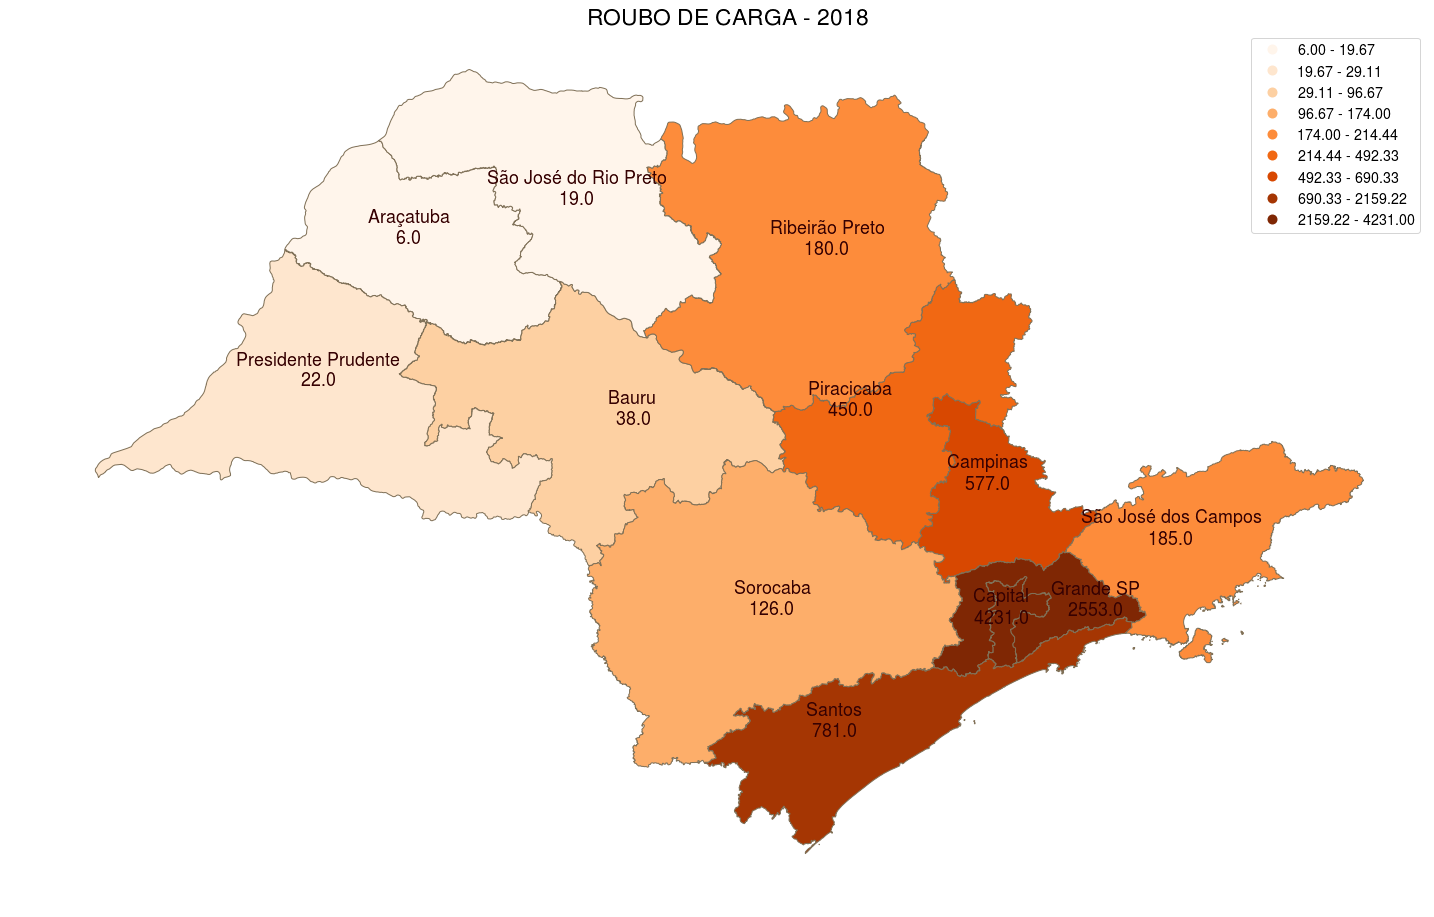

In [156]:
anos = np.sort(df_final['ano'].unique()).tolist()
var = "ROUBO DE CARGA"
for ano in anos[16:17]:
    plot_map(df_final,var,ano)
    
    


### Save Gif

In [159]:
anos = np.sort(df_final['ano'].unique()).tolist()
var = "OCORRÊNCIAS DE APREENSÃO DE ENTORPECENTES(1)"

kwargs_write = {'fps':1.0, 'quantizer':'nq'}
imageio.mimsave('{}.gif'.format(var), [plot_map(df_final,var,ano) for ano in anos], fps=1)